## k-vs-(N-k) Flu ABM Env
- k-vs-(N-k) experiment
- Kicking tires on multiplayer instance of Flu ABM with RL learners 
- MADDPG/MAC RL algo

In [1]:
import itertools, importlib, sys, warnings, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
# warnings.filterwarnings("ignore")

log_path = './log/flu'
#tensorboard --logdir=flugame_worker_1:'./log/train_rf_flugame_worker'

## suppress annoy verbose tf msgs
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '3' to block all including error msgs
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Tensorflow version: 1.15.0


In [2]:
sys.path.append('./embodied_arch')
import embodied_arch.embodied_central_Qcritic as emac
importlib.reload(emac)

<module 'embodied_arch.embodied_central_Qcritic' from '/mnt/Lebesgue/Documents/Research/Coding/Python/rlabms/embodied_arch/embodied_central_Qcritic.py'>

In [3]:
import flumodel_python.flu_env as Fenv
from embodied_misc import ActionPolicyNetwork, ValueNetwork, SensoriumNetworkTemplate

## Env Setup

In [4]:
# exos = [1,2,3,10]  # (np.random.sample(33) < 0.3)
exos = (np.random.sample(9223) < 0.004)
exos = [j for j in range(len(exos)) if exos[j]==True]
print(len(exos))

importlib.reload(Fenv);
importlib.reload(emac);

36


In [5]:
tf.reset_default_graph()
flu_menv = Fenv.Flu_env(
    exo_idx=exos,
    model_path="./flumodel_python/"
)

In [6]:
print(flu_menv.actor_count)
print(flu_menv.state_space_size, flu_menv.action_space_size)

36
8 1


### MARL Setup Demo

In [7]:
actor = lambda s: ActionPolicyNetwork(s, hSeq=(8,), gamma_reg=1e-1)
value = lambda s: ValueNetwork(s, hSeq=(8,), gamma_reg=1.)
sensor = lambda st, out_dim: SensoriumNetworkTemplate(st, hSeq=(16,8,8,), out_dim=out_dim, gamma_reg=5.)

# num_episodes, n_epochs, max_len = (5, 4, 5)
# num_episodes, n_epochs, max_len = (100, 1501, 35)
# num_episodes, n_epochs, max_len = (10, 400, 25)
# num_episodes, max_len, n_epochs, evry = (100, 35, 1501, 300)
num_episodes, max_len, n_epochs, evry = (100, 35, 501, 100)

In [8]:
flumac = emac.EmbodiedAgent_MAC(
    name="flu_MAC", env_=flu_menv, 
    alpha_p=5e3, alpha_v=5e2, alpha_q=50,
    actorNN=actor, valueNN=value,
    sensorium=sensor,latentDim=4, 
    max_episode_length=max_len, _every_=evry
)

In [9]:
# flumrf = emi.EmbodiedAgent_IRFB(
#     name="flu_mRFB",
#     env_=flu_menv,
#     alpha_p=5e3, alpha_v=5e2,
#     max_episode_length=max_len,
#     latentDim=4, 
#     actorNN=actor, sensorium=sensor
# )

In [10]:
# ??flumac.play
(flumac.a_size, flumac.env.action_space_size)

(1, 1)

In [11]:
sess = tf.InteractiveSession()
flumac.init_graph(sess) # note tboard log dir
saver = tf.train.Saver(max_to_keep=1) 

Tensorboard logs in:  ./log/train_flu_MAC


## Baseline

In [12]:
print('Baselining untrained pnet...')
rwds0 = []
acts_cov = np.zeros([flumac.actor_count,flumac.actor_count])
for k in range(num_episodes):
    flumac.play(sess, terminal_reward=0.);
    rwds0.append(flumac.last_total_returns)
    actions = np.array(flumac.episode_buffer['actions']).T
    acts_cov = acts_cov + (np.cov(actions)/num_episodes)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

# Compute average rewards
base_perf = 100.*np.mean(np.array(rwds0)/float(flumac.max_episode_length))
base_per_agent = 100.*np.mean(np.array(rwds0)/float(flumac.max_episode_length), axis=0)

print("\nAgent is flu-free for an average of {}pct of seasons".format(
    1.*base_perf))

Baselining untrained pnet...
Episode 99/100
Agent is flu-free for an average of 95.0174603174603pct of seasons


Agent Action Correlations:


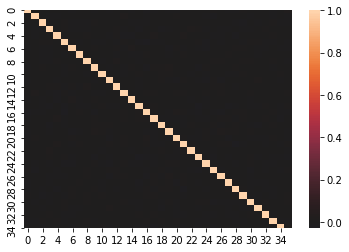

In [13]:
acts_corr = acts_cov.copy()
jm, km = acts_corr.shape
for j in range(jm):
    for k in range(km):
        denom = np.sqrt((acts_corr[j,j])*(acts_corr[k,k]))
        acts_corr[j,k] = acts_corr[j,k]/denom

print("Agent Action Correlations:")
sns.heatmap(acts_corr, center=0)

## Train Agent Population

	Iteration 0: Value loss([ 8.732133  11.24936   13.505728  20.074743  22.278643  -1.7486382
 25.093056  21.602602  22.66889   18.621239  26.825117  12.943111
  1.5420241 22.736675   4.0573783  7.4793353 23.641571  10.582061
 22.224302   9.542278  10.1884    25.123718  17.221462  29.108358
 17.982595  24.036434   9.162384  31.04361   15.354522   8.90302
	Iteration 1: Value loss([ 2.343012   6.2714715  3.544758   3.7368836  3.1452816  9.9876375
  2.1292348 -0.8561055  5.8147526  2.49711    5.473196  11.913862
  8.7403755 -2.2637835  4.7561507  3.7147033  1.0247278  9.262022
  6.6600394  7.1340313  4.37711    6.3234925 -1.1020112  1.5135849
  2.1384892  5.1149607  7.2377744 10.238099  10.097609  10.415916
	Iteration 2: Value loss([ 8.950622   19.470041   10.05114     2.3488758   0.81098497 21.210262
 10.284997    4.2246265  10.282001    6.7300143   7.208761   13.132583
 15.070961    1.5469548  16.977694   12.375676    8.303149   14.415512
  3.7585723  16.594423   11.991639   10.059174    

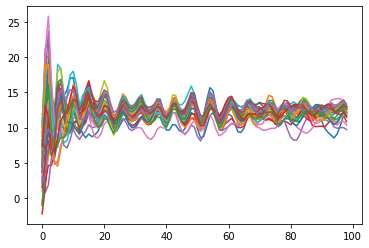

In [14]:
obs = []
for ct in range(100):
    flumac.play(sess)
    tmp = flumac.train_eval_QC(sess)
    obs.append(np.mean(tmp, axis=0))
    print('\r\tIteration {}: Value loss({})'.format(ct, np.mean(tmp, axis=0)), end="")
plt.plot(obs[1:])

In [15]:
# ### Train Agents
print('Training...')
hist = flumac.work(sess, num_epochs=n_epochs, saver=saver)

Training...
Starting agent flu_MAC
Epoch no.: 0/501

	Stats @Step 0: 	(Min, Mean, Max)
Perf/Recent Rewards: (25.0, 33.388888888888886, 35.0)
Losses/Policy LLs: (-2.5227714, -0.568197, -0.083639175)
Losses/Policy Entropies: (0.2793476, 0.58922553, 0.69314486)
Values/Critic Scores: (-3.4368932, -0.03750165, 3.1458106)
Values/Mean Q Scores: (12.796963, 17.338827, 19.067532)
Saved Model
Epoch no.: 100/501

	Stats @Step 100: 	(Min, Mean, Max)
Perf/Recent Rewards: (28.0, 33.0, 35.0)
Losses/Policy LLs: (-2.1824055, -0.5690772, -0.0034128875)
Losses/Policy Entropies: (0.022759888, 0.58830935, 0.69300663)
Values/Critic Scores: (-3.0706851, -0.03608963, 3.9822707)
Values/Mean Q Scores: (18.635437, 24.153812, 26.12426)
Saved Model
Epoch no.: 200/501

	Stats @Step 200: 	(Min, Mean, Max)
Perf/Recent Rewards: (30.0, 33.69444444444444, 35.0)
Losses/Policy LLs: (-2.035418, -0.58416486, -0.015210656)
Losses/Policy Entropies: (0.07828196, 0.580902, 0.6929983)
Values/Critic Scores: (-3.315652, 0.33681354

## Test

In [16]:
# Test pnet!
print('Testing...')
rwds = []
acts_cov_trained = np.zeros([flumac.actor_count,flumac.actor_count])
for k in range(num_episodes):
    flumac.play(sess)
    rwds.append(flumac.last_total_returns)
    actions = np.array(flumac.episode_buffer['actions']).T
    acts_cov_trained = acts_cov_trained + (np.cov(actions)/num_episodes)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

trained_perf = 100.*np.mean(np.array(rwds)/float(flumac.max_episode_length))
trained_per_agent = 100.*np.mean(np.array(rwds)/float(flumac.max_episode_length), axis=0)

print("\nAgent is flu-free for an average of {} pct compared to baseline of {} pct".format(
    1.*trained_perf, 1.*base_perf) )

Testing...
Episode 99/100
Agent is flu-free for an average of 95.58253968253968 pct compared to baseline of 95.0174603174603 pct


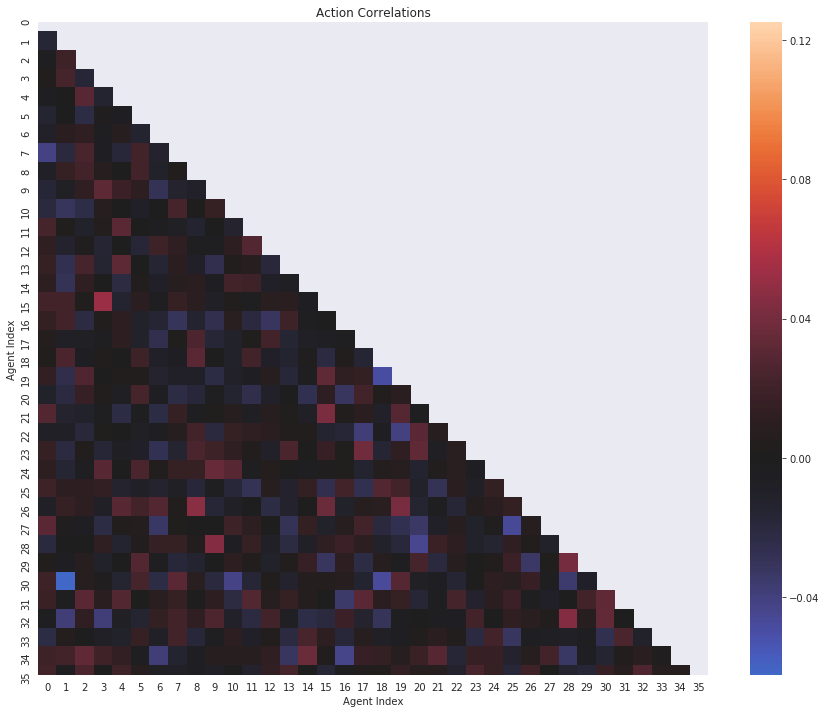

In [17]:
acts_corr_trained = acts_cov_trained.copy()
jm, km = acts_corr_trained.shape
for j in range(jm):
    for k in range(km):
        denom = np.sqrt((acts_cov_trained[j,j])*(acts_cov_trained[k,k]))
        acts_corr_trained[j,k] = acts_corr_trained[j,k]/denom

mask = np.zeros_like(acts_corr_trained)
mask[np.triu_indices_from(mask,k=0)] = True
with sns.axes_style("darkgrid"):
    plt.rcParams['figure.figsize'] = (15, 12)
    ax = sns.heatmap(acts_corr_trained, 
                     mask=mask, vmax=0.125, center=0)
    ax.set_ylabel("Agent Index")
    ax.set_xlabel("Agent Index")
    ax.set_title("Action Correlations")

## Evaluate

In [18]:
rwds0_df = pd.DataFrame(100.*(np.array(rwds0)/float(flumac.max_episode_length)))
rwds_df = pd.DataFrame(100.*(np.array(rwds)/float(flumac.max_episode_length)))

rwds0_df['Wave'] = "Baseline"
rwds_df['Wave'] = "Trained"

resDF = pd.concat([rwds0_df, rwds_df])
resDF.columns = ["Agent"+str(tc) if tc is not "Wave" else tc for tc in resDF.columns]
# resDF['id'] = resDF.index
print(resDF.shape)
# resDF.head()


(200, 37)


In [19]:
resDF = resDF.melt(
    id_vars=['Wave'], #['id', 'Wave'],
    value_vars=[tc for tc in resDF.columns if "Agent" in tc]
)
resDF = resDF.rename(columns={"variable": "Agent", "value": "Immune_pct"})
print(resDF.shape)

res_tabs = resDF.groupby(['Agent','Wave']).aggregate(['mean','std']) # res_tabs

# resDF.head()

(7200, 3)


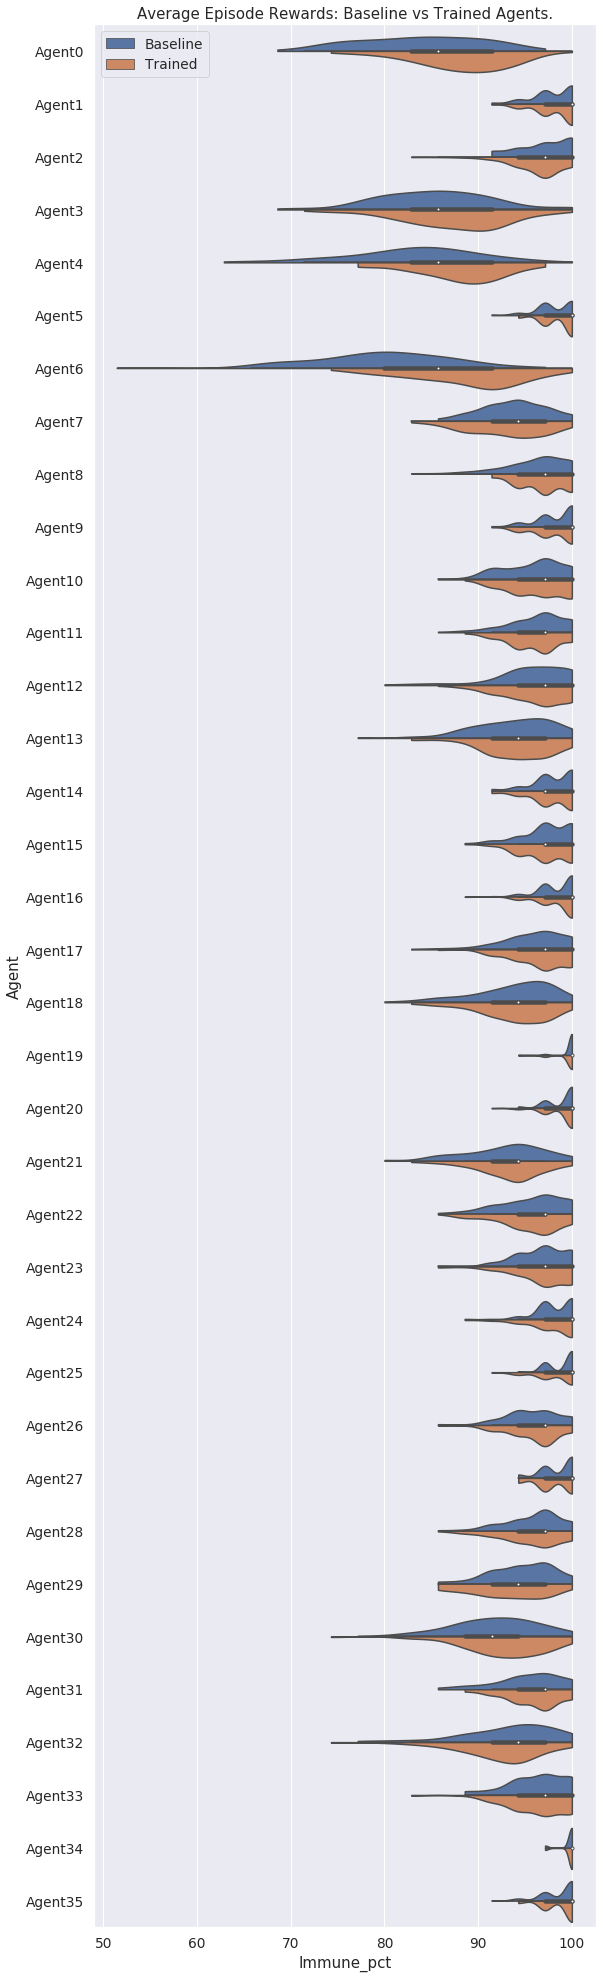

In [20]:
plt.rcParams['figure.figsize'] = (9, 35)
sns.set(font_scale=1.25)

fig = sns.violinplot(data=resDF, inner="box", cut=0,
                     x="Immune_pct", y="Agent", hue="Wave",
                     split=True);
fig.set_title(
    'Average Episode Rewards: Baseline vs Trained Agents.');
fig.legend(loc='upper left');

In [21]:
base_meanDF = resDF[resDF.Wave=="Baseline"].groupby(['Agent']).aggregate(['mean'])
base_meanDF.sort_index(inplace=True)

trained_meanDF = resDF[resDF.Wave=="Trained"].groupby(['Agent']).aggregate(['mean'])
trained_meanDF.sort_index(inplace=True)

mean_diffDF = (trained_meanDF - base_meanDF)
mean_diffDF.columns = ['Mean_Immune_Pct_Change']
# mean_diffDF.head()

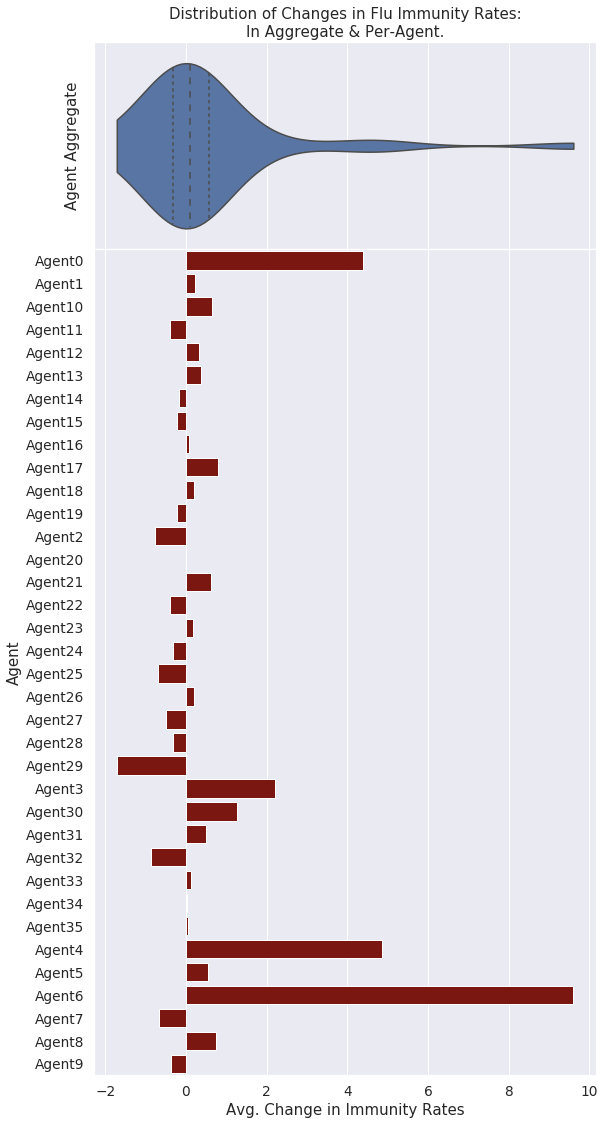

In [22]:
plt.rcParams['figure.figsize'] = (9, 19)
sns.set_color_codes("dark")
fig, axs = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [1,4]})
cmp = sns.violinplot(x='Mean_Immune_Pct_Change', cut=0, inner='quartile',
                     data=mean_diffDF, ax=axs[0])
axs[0].set_ylabel('Agent Aggregate');
axs[0].set_title(
    'Distribution of Changes in Flu Immunity Rates:\nIn Aggregate & Per-Agent.'
);

sns.barplot(y=mean_diffDF.index, x="Mean_Immune_Pct_Change", 
            data=mean_diffDF, color="r",
            label="Success Rate", ax=axs[1]);
plt.subplots_adjust(wspace=0, hspace=0)
axs[1].set_xlabel('Avg. Change in Immunity Rates');

### Baseline for Default Behavioral Model

In [24]:
import flumodel_python.flu_env_basic as FABM
# ?Fenv.Flu_ABM
importlib.reload(FABM);
flu = FABM.Flu_ABM(model_path="./flumodel_python/")

# Burn-in Flu ABM First...
for _ in range(30):
    _ = flu.stepAll()

In [25]:
flu_hist = np.zeros([num_episodes, len(exos)])
for k in range(num_episodes):
    tmp = np.zeros(len(exos))
    for _ in range(max_len):
        tmp += (1.-np.array(flu.stepAll(), dtype=float))[exos]
    flu_hist[k,:] = tmp

In [26]:
rwds_dbm = 100.*flu_hist/float(max_len)
print(len(exos), rwds_dbm.shape, 
      np.mean(rwds_dbm, axis=0).shape)

36 (100, 36) (36,)


In [27]:
print(np.mean(rwds_dbm), "\n",
      np.mean(rwds_dbm, axis=0)
     )

95.23015873015873 
 [88.85714286 98.85714286 95.2        82.71428571 86.82857143 98.94285714
 83.         91.77142857 97.42857143 97.4        95.28571429 95.74285714
 97.31428571 93.94285714 97.77142857 97.57142857 98.82857143 97.62857143
 94.74285714 99.71428571 98.94285714 93.57142857 94.97142857 96.
 98.65714286 98.54285714 96.85714286 98.28571429 94.82857143 92.51428571
 93.22857143 94.05714286 94.37142857 95.62857143 99.74285714 98.54285714]


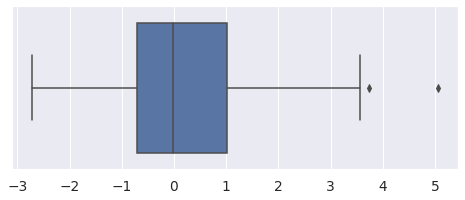

In [28]:
plt.rcParams['figure.figsize'] = (8,3)
sns.boxplot(np.mean(rwds_dbm, axis=0) - base_per_agent)

### Compare to Default Behavioral Model

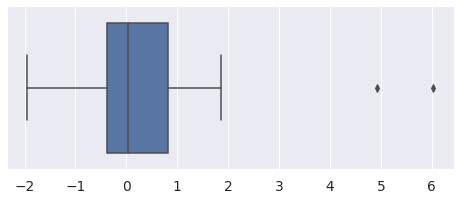

In [29]:
trcmp = 100.*(np.array(rwds)/float(flumac.max_episode_length))
cmp = np.mean((trcmp-rwds_dbm), axis=0)
sns.boxplot(cmp)

In [30]:
plt.rcParams['figure.figsize'] = (8,3)
np.mean(trcmp - np.mean(rwds_dbm, axis=0))

0.35238095238097217